In [1]:
import numpy as np
from sklearn.utils import shuffle
from skimage import io
from skimage.transform import resize
from skimage.color import rgba2rgb
import matplotlib.pyplot as plt
import os, random, string

In [2]:
class dataset:
    # Calcula el número de imágenes para cada set
    def calculate(self, amount, percent):
        train = amount * percent / 100
        test = amount - train
        e =     {"train":round(train),
                "test":round(test)}
        return e
    # Renombra las imágenes
    def rename(self, path):
        random.seed(42)
        # Por cada carpeta en el directorio del script
        for folder in os.listdir(path):
            # Parte el contador de nuevo nombre en 0
            new_name=0
            # Dirección de la carpeta de imágenes
            folder_path = os.path.join(path,folder)
            print("[+] Renaming data in", folder_path)
            # Verifica si existe la carpeta
            if os.path.isdir(folder_path):
                for img_name in os.listdir(folder_path):
                    # Renombra todas las imagenes con nombres aleatorios
                    new_img_name = ''.join(random.choice(string.ascii_letters) for i in range(32))
                    img_path = os.path.join(folder_path, img_name)
                    new_img_path = os.path.join(folder_path, new_img_name)
                    os.rename(img_path, new_img_path)
                # Por cada imágen en la carpeta
                for img_name in os.listdir(folder_path):
                    try:
                        # Define la extensión
                        extension = os.path.splitext(img_name)[1]
                        # Define la ruta de la imágen
                        img_path = os.path.join(folder_path, img_name)
                        # Define la ruta del nuevo nombre
                        new_img_path = os.path.join(folder_path,"img_"+str(new_name) + extension)
                        # Lee el contenido de la imágen
                        img_file = io.imread(img_path)
                        # Verifica si es una imagen RGB (3 dim) o RGBA (4 dim)
                        if img_file.shape[-1]==4:
                            extension = ".jpg"
                            print("[*] Converting",img_name,"RGBA to RGB")
                            # Si es RGBA la convierte a RGB
                            rgb_img = rgba2rgb(img_file)
                            new_img_path = os.path.join(folder_path, "img_"+str(new_name) + extension)
                            io.imsave(new_img_path, rgb_img)
                            os.remove(img_path)
                        else:
                            # De no ser así solo le cambia el nombre
                            os.rename(img_path, new_img_path)
                        # Actualiza el contador de nuevo nombre de imágen
                        new_name+=1
                    # Atrapa el error en caso de que el archivo ya exista
                    except Exception as e:
                        print(f"[*] Error renaming file {img_name}: {e}")
        print("[*] Done!") 
    # Crea el dataset
    def create(self, path, percent, *size):
        # Lista las carpetas
        folders = os.listdir(path)
        # Si existen las dos carpetas necesarias
        if "yes" in folders and "no" in folders:
            # Listas para cada set
            x_train_set_orig = []
            y_train_set = []
            x_test_set_orig = []
            y_test_set = []
            print("[*] Folder 'yes' and 'no' found") 
            # Por cada carpeta ['si', 'no']
            for folder in folders:
                # Define la ruta de la carpeta
                folder_path = os.path.join(path, folder)
                # Verifica si existe la carpeta
                if os.path.isdir(folder_path):
                    # Verifica si la carpeta es una de las necesarias
                    if folder=="yes" or folder=="no":
                        # Lista el contenido de la carpeta
                        folder_content = os.listdir(folder_path)
                        # Calcula la cantidad de imágenes para cada set en base al porcentaje dado
                        e = self.calculate(len(folder_content), percent)
                        train = e["train"]
                        test = e["test"]
                        print("\n[*] Folder:\t", folder)
                        print("[*] Images:\t", len(folder_content))
                        print("[*] Training:\t", train)
                        print("[*] Test:\t", test)
                        # Por cada imágen
                        for img in folder_content:
                            # Define la ruta de la imágen
                            img_path = os.path.join(folder_path, img)
                            # Lee el contenido de la imágen
                            array_img = io.imread(img_path)
                            # Ajusta el tamaño de la imágen
                            image = resize(array_img, size[0], anti_aliasing=False, preserve_range=True)
                            # Verifica si el índice de la imágen no es mayor al número de training
                            if folder_content.index(img) < train:
                                # Agrega la imágen a la lista
                                x_train_set_orig.append(image)
                                # Verifica la carpeta para definir la etiqueta
                                if folder == "yes":
                                    y_train_set.append(1)
                                else:
                                    y_train_set.append(0)
                            # De ser el índice mayor al número de training, agrega a testing
                            else:
                                x_test_set_orig.append(image)
                                # Verifica la carpeta para definir la etiqueta
                                if folder == "yes":
                                    y_test_set.append(1)
                                else:
                                    y_test_set.append(0)                               
                    else:
                        print("[*] Folder", folder, "ignored")
            print("\n[*] Successfully generated dataset!")    
        else:
            raise Exception("[!] No folder 'yes' or 'no' found")  
        # Pasa las listas a arreglos
        x_train_set_orig = np.array(x_train_set_orig)
        x_test_set_orig = np.array(x_test_set_orig)
        y_train_set = np.array(y_train_set)
        y_test_set = np.array(y_test_set)
        # Distribuye las imágenes de forma consistente 
        x_train_set_orig, y_train_set = shuffle(x_train_set_orig, y_train_set, random_state=42)
        x_test_set_orig, y_test_set = shuffle(x_test_set_orig, y_test_set, random_state=42)
        # Re-estructura el arreglo para que queden las 3 dimensiones de pixeles
        # en una sola vertical, con las imágenes en columnas horizontales
        # (Ajustando el tamaño del arreglo y luego transponiéndolo)
        x_train_set_flat = x_train_set_orig.reshape(x_train_set_orig.shape[0],-1).T
        x_test_set_flat = x_test_set_orig.reshape(x_test_set_orig.shape[0],-1).T
        # Normaliza la intensidad de los píxeles en función de su valor máximo (255)
        x_train_set = x_train_set_flat/255
        x_test_set = x_test_set_flat/255
        # Retorna los sets
        cds = {"x_train_set":x_train_set, 
            "x_test_set":x_test_set,
            "y_train_set":y_train_set,
            "y_test_set":y_test_set}
        return cds

In [3]:
class perceptron:
    # Función regresión logística
    # Aplicando vectorización de matrices
    def logistic_regression(self, w, b, X):
        z = np.dot(w.T, X) + b
        return z
    # Función sigmoide
    def sigmoid(self, z):
        return 1/(1+np.exp(-z))
    # Optimización de la función de coste
    def propagate(self, X, Y, w, b):
        # Número de características (imágenes)
        m = X.shape[1]
        # Regresión logística
        z = self.logistic_regression(w, b, X)
        # Resultado de función sigmoide
        A = self.sigmoid(z)
        # Resultado función de coste
        cost = -((1 / m) * (np.sum(Y * np.log(A) + (1 - Y) * np.log(1 - A))))
        # Derivadas de pesos W y b
        dw = (1 / m) * np.dot(X, (A - Y).T)
        db = (1 / m) * np.sum(A - Y)
        grads = {"dw":dw, "db":db, "A":A}
        return grads, cost
    # Gradiente descendiente
    def optimize(self, w, b, X, Y, ni, lr, ur):
        # Lista de costes
        costs = []
        # Por el total de épocas
        for i in range(ni):
            # Genera las derivadas
            grads, cost = self.propagate(X, Y, w, b)
            dw = grads["dw"]
            db = grads["db"]
            # Optimiza los valores de W y b
            w = w - lr * dw
            b = b - lr * db
            # Imprime el coste si es múltiplo de 100
            if i % ur == 0:
                print("Iter:",i, "Cost:", str(cost))
                costs.append(cost)
        # Entrega los parámetros
        params = {"w":w, "b":b}
        return params, costs
    # Predicciones
    def predict(self, w, b, X):
        # Número de imágenes
        m = X.shape[1]
        # Arreglo de ceros con tamaño de Y
        y_predict = np.zeros((1, m))
        # Hace la predicción mediante regresión logística
        z = self.logistic_regression(w, b, X)
        # Aplicando función sigmoide
        A = self.sigmoid(z)
        # Por cada una de las imágenes
        for i in range(A.shape[1]):
            # Redondeando el resultado de la predicción para resultado binario
            y_predict[0,i] = round(A[0,i])
        return y_predict
    # Creación de modelo
    def model(self, X, Y, Xt, Yt, ni=2000, lr=0.5, ur=100):
        # Arreglos inicializados en cero de W y b
        w, b = np.zeros((X.shape[0],1)), 0
        # Recibe parámetros de la gradiente descendiente
        params, costs = self.optimize(w, b, X, Y, ni, lr, ur)
        w = params["w"]
        b = params["b"]
        # Predice en función del modelo
        y_predict_train = self.predict(w, b, X)
        y_predict_test = self.predict(w, b, Xt)
        print("Exactitud de entrenamiento: \t", str( 100 - np.mean(np.abs(y_predict_train - Y) * 100)))
        print("Exactitud de prueba: \t", str(100 - np.mean(np.abs(y_predict_test - Yt) * 100)))
        d = {"y_predict_train":y_predict_train, "y_predict_test":y_predict_test, "costs":costs}
        return d

In [4]:
ds = dataset()

In [5]:
ds.rename("datasets/pikachu")

[+] Renaming data in datasets/pikachu/yes
[+] Renaming data in datasets/pikachu/no
[*] Done!


In [6]:
cds = ds.create("datasets/pikachu", 70, (100,100))
x_train_set = cds["x_train_set"]
y_train_set = cds["y_train_set"]
x_test_set = cds["x_test_set"]
y_test_set = cds["y_test_set"]

[*] Folder 'yes' and 'no' found

[*] Folder:	 yes
[*] Images:	 152
[*] Training:	 106
[*] Test:	 46

[*] Folder:	 no
[*] Images:	 110
[*] Training:	 77
[*] Test:	 33

[*] Successfully generated dataset!


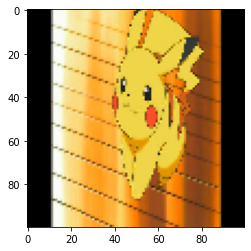

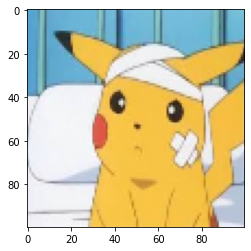

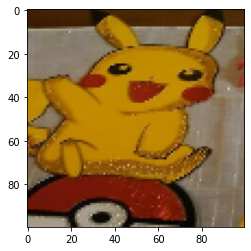

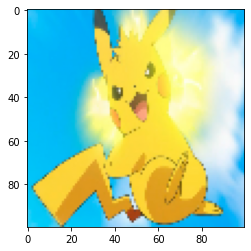

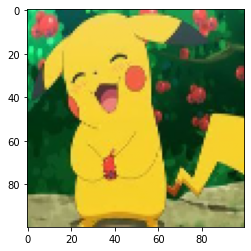

In [7]:
for index in range(5):
    plt.imshow(x_test_set[:,index].reshape(100,100,3))
    plt.show()

In [8]:
# Instancia del perceptrón
p = perceptron()
# Entrenamiento del perceptron
# Train: 70
# Test; 30
# Epochs: 50000
# Learning Rate: 0.01
# Update Rate: 10000
d = p.model(x_train_set, y_train_set, x_test_set, y_test_set, ni=50000, lr=0.01, ur=10000)

Iter: 0 Cost: 0.6931471805599453


/tmp/ipykernel_61260/1828001295.py:19: RuntimeWarning: divide by zero encountered in log
  cost = -((1 / m) * (np.sum(Y * np.log(A) + (1 - Y) * np.log(1 - A))))
/tmp/ipykernel_61260/1828001295.py:19: RuntimeWarning: invalid value encountered in multiply
  cost = -((1 / m) * (np.sum(Y * np.log(A) + (1 - Y) * np.log(1 - A))))


Iter: 10000 Cost: 0.0005461405791213249
Iter: 20000 Cost: 0.00028154393124787215
Iter: 30000 Cost: 0.00018988779199258755
Iter: 40000 Cost: 0.00014331335421738372
Exactitud de entrenamiento: 	 100.0
Exactitud de prueba: 	 91.13924050632912


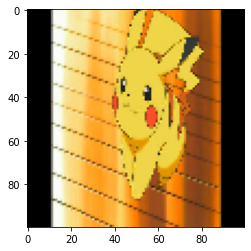

y = 1, you predicted: 1.0


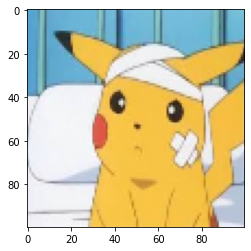

y = 1, you predicted: 1.0


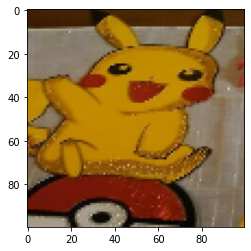

y = 1, you predicted: 1.0


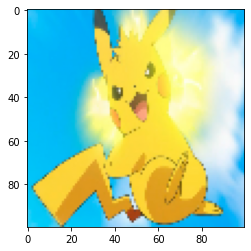

y = 1, you predicted: 1.0


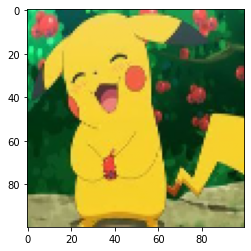

y = 1, you predicted: 1.0


In [9]:
# Predicciones
# Train: 100.0
# Test: 91.1
for index in range(5):
    plt.imshow(x_test_set[:,index].reshape(100,100,3))
    plt.show()
    print("y = " + str(y_test_set[index]) + ", you predicted: " + str(d["y_predict_test"][0,index]))

In [10]:
print("n error:",np.count_nonzero(y_test_set.reshape(-1,1) - d["y_predict_test"].reshape(-1,1)))
print("n total:", len(y_test_set))
print("% error",np.count_nonzero(y_test_set.reshape(-1,1) - d["y_predict_test"].reshape(-1,1)) * 100 / len(y_test_set))

n error: 7
n total: 79
% error 8.860759493670885
